# Import Packages

In [7]:
import itertools
import sys

sys.path.append('../')

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

In [15]:
from datasets import load_data
from src.gaussian_mixture import GMMModelSelection
from src.merge_components import (
    EntMergeComponents,
    NEnt1MergeComponents,
    DEMPMergeComponents,
    DEMP2MergeComponents,
    mc,
    MCMergeComponents,
    nmc,
    NMCMergeComponents
)

# Experiment

In [17]:
def _hz(
    prob,
    weights=None
):
    N = len(prob)
    if weights is None:
        weights = np.ones(N)

    rho = np.dot(weights, prob) / np.sum(weights)
    H_Z = - np.dot(rho, np.log(rho + 1e-50))
    return H_Z

In [18]:
def _ent_label(z):
    z_norm = z / sum(z)
    return - np.dot(z_norm, np.log(z_norm + 1e-50))

In [19]:
z_ent_list = []
mc_list = []
nmc_list = []

for data_name, algorithm_class, random_state in tqdm(itertools.product(
    [
        'AIS',
        'beetles',
        'crabs',
        'DLBCL',
        'ecoli',
        'seeds',
        'wisconsin',
        'yeast'
    ],
    [
        EntMergeComponents,
        NEnt1MergeComponents,
        DEMPMergeComponents,
        DEMP2MergeComponents,
        MCMergeComponents,
        NMCMergeComponents
    ],
    np.arange(10)
)):
    # load data
    X, Z_true = load_data(data_name, scaling=True)

    # fit GMM
    gmm = GMMModelSelection(
        K_max=20,
        mode='BGMM',
        reg_covar=1e-3,
        weight_concentration_prior=0.1,
        random_state=random_state
    )
    gmm.fit(X)
    prob_0 = gmm.prob_latent(X)
    
    # delete 0 prob
    prob_0 = np.delete(prob_0, (np.sum(prob_0, axis=0) < 1e-50), axis=1)
    prob_0 = prob_0 / np.sum(prob_0, axis=1).reshape((-1, 1))
    
    # fit Merge Algorithm
    algorithm = algorithm_class()
    algorithm.fit(prob_0)

    for K in range(1, prob_0.shape[1]):
        prob_merged = algorithm.prob_merged(prob_0, K)
        Z_pred = np.argmax(prob_merged, axis=1)
        members_nmc = algorithm.members_list_[prob_0.shape[1] - K]
        # z_martix[i][j] = #{n | Z_pred[n] = i, Z_true[n]=j}
        index = np.sort(np.unique(Z_pred))
        columns = np.sort(np.unique(Z_true))
        z_matrix = np.zeros([len(index), len(columns)], dtype=int)
        for n in range(len(X)):
            i_n = np.where(index == Z_pred[n])[0][0]
            j_n = np.where(columns == Z_true[n])[0][0]
            z_matrix[i_n][j_n] += 1
        
        for i, k in enumerate(index):
            # weights and probabilties for Component k
            weights = np.sum(prob_0[:, members_nmc[k]] + 1e-50, axis=1)
            prob_k = (prob_0[:, members_nmc[k]] + 1e-50) / weights.reshape([-1, 1])
            
            # add z_ent, mc, nmc
            mc_list.append(mc(prob_k, weights=weights))
            z_ent_list.append(_ent_label(z_matrix[i]))
            if _hz(prob_k, weights=weights) < 1e-15:
                nmc_list.append(np.nan)
            else:
                nmc_list.append(nmc(prob_k, weights=weights))

In [21]:
z_ent_list = np.array(z_ent_list)
mc_list = np.array(mc_list)
nmc_list = np.array(nmc_list)

# Results

## MC and Entropy

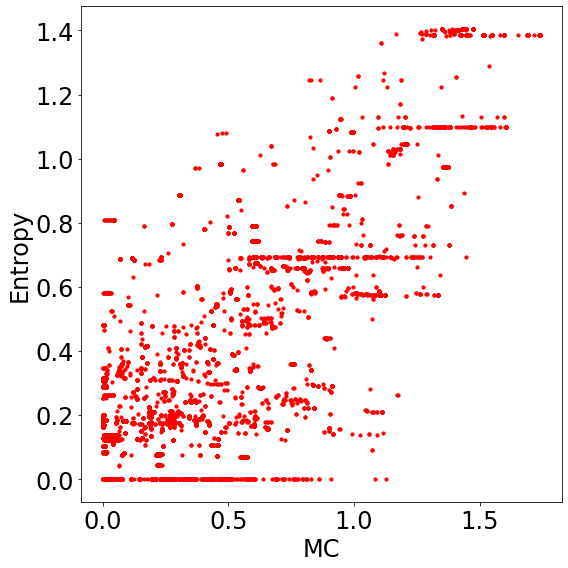

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(mc_list[~np.isnan(nmc_list)], z_ent_list[~np.isnan(nmc_list)], s=10, color='red')
ax.tick_params(labelsize=24)
ax.set_xlabel('MC', fontsize=24)
ax.set_ylabel('Entropy', fontsize=24)
plt.tight_layout()

In [23]:
np.corrcoef(mc_list[~np.isnan(nmc_list)], z_ent_list[~np.isnan(nmc_list)])

array([[1.        , 0.79411041],
       [0.79411041, 1.        ]])

## NMC and Entropy

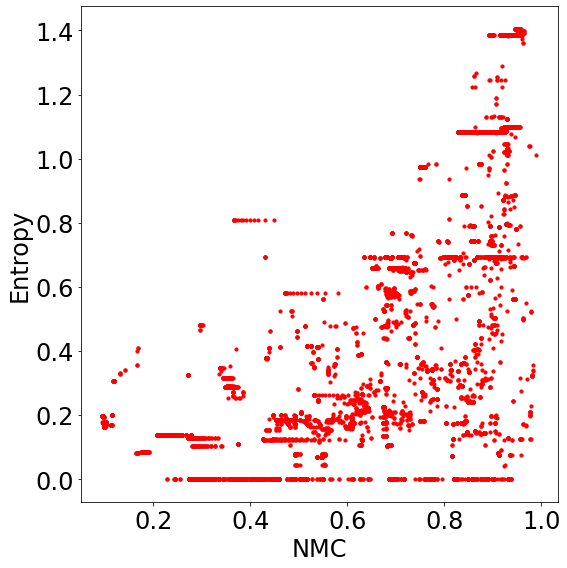

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(nmc_list[~np.isnan(nmc_list)], z_ent_list[~np.isnan(nmc_list)], s=10, color='red')
ax.tick_params(labelsize=24)
ax.set_xlabel('NMC', fontsize=24)
ax.set_ylabel('Entropy', fontsize=24)
plt.tight_layout()

In [26]:
np.corrcoef(nmc_list[~np.isnan(nmc_list)], z_ent_list[~np.isnan(nmc_list)])

array([[1.        , 0.63745792],
       [0.63745792, 1.        ]])